<a href="https://colab.research.google.com/github/sxfrul/titanic-ai-model/blob/main/Titanic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [1]:
!pip install -q sklearn

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf

# LOAD DATASET

In [21]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
dftrain.head()

# change parch into str
dftrain = dftrain.astype({"parch":"string"})
dfval = dfval.astype({"parch":"string"})
print(dftrain.dtypes)
dftrain.head()

survived                int64
sex                    object
age                   float64
n_siblings_spouses      int64
parch                  string
fare                  float64
class                  object
deck                   object
embark_town            object
alone                  object
dtype: object


,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


# INPUT PIPELINE

In [4]:
# INPUT PIPELINE
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop("survived")
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds


In [5]:
batch_size = 20
train_ds = df_to_dataset(dftrain, batch_size=batch_size)
val_ds = df_to_dataset(dfval, batch_size=batch_size)

<ipython-input-4-7a8a0a162d20>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


# NORMALIZING NUMERICAL COLUMNS

In [6]:
#Normalize numerical data
def get_normalization_layer(name, dataset):
  # create a normalization layer for feature
  normalizer = tf.keras.layers.Normalization(axis=None)

  # prepare a ds that only yields the feature
  feature_ds = dataset.map(lambda x,y: x[name])

  # adapt to data?
  normalizer.adapt(feature_ds)

  return normalizer

In [7]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['embark_town'])
print('A batch of targets:', label_batch )

Every feature: ['survived', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
A batch of ages: tf.Tensor(
[[b'Southampton']
 [b'Southampton']
 [b'Queenstown']
 [b'Southampton']
 [b'Southampton']
 [b'Southampton']
 [b'Cherbourg']
 [b'Southampton']
 [b'Southampton']
 [b'Cherbourg']
 [b'Southampton']
 [b'Southampton']
 [b'Southampton']
 [b'Cherbourg']
 [b'Southampton']
 [b'Southampton']
 [b'Southampton']
 [b'Southampton']
 [b'Southampton']
 [b'Southampton']], shape=(20, 1), dtype=string)
A batch of targets: tf.Tensor([1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0], shape=(20,), dtype=int64)


In [8]:
#loops through every numerical columns to be normalized
NUMERICAL_COLUMNS = ["age", "fare", "n_siblings_spouses"]

all_inputs = []
encoded_features = []

for header in NUMERICAL_COLUMNS:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

# ENCODING CATEGORICAL COLUMNS

In [9]:
#Encoding categorical columns (from string to numbers)
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = tf.keras.layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [10]:
test_type_col = train_features['embark_town']
test_type_layer = get_category_encoding_layer(name='embark_town',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(20, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [11]:
# loop through every categorical column to be encoded(one-hot)
CATEGORICAL_COLUMNS = ["sex", "class", "deck", "embark_town", "alone", "parch"]

for header in CATEGORICAL_COLUMNS:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

# CREATE THE MODEL

In [12]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

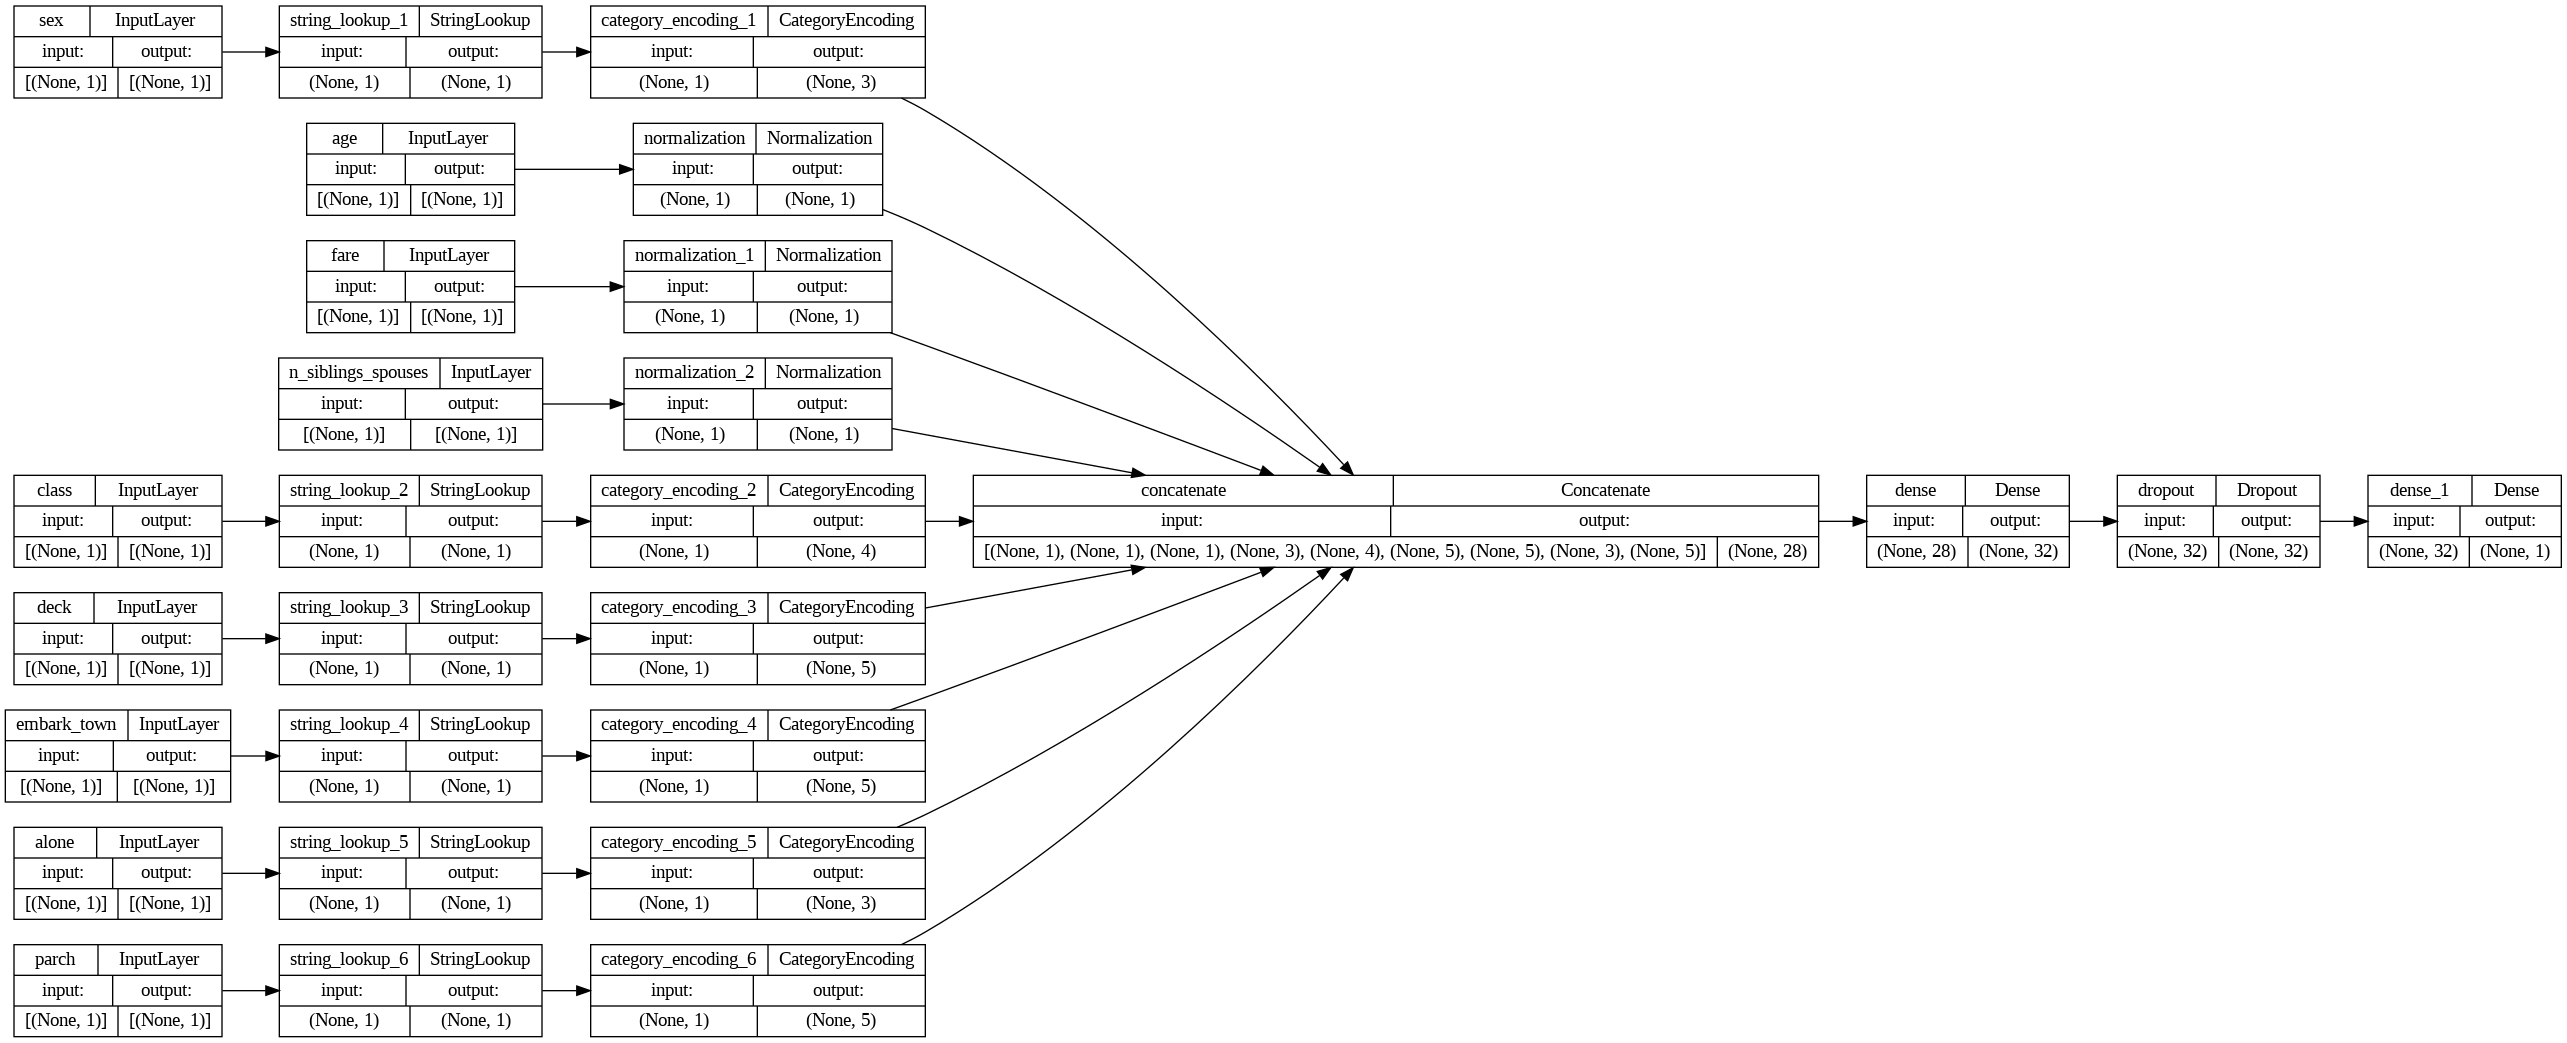

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Train and evaluate model

In [19]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

loss, accuracy = model.evaluate(val_ds)
print("Accuracy", accuracy)

Epoch 1/10
32/32 [==============================] - 0s 4ms/step - loss: 0.4221 - accuracy: 0.8214 - val_loss: 0.4372 - val_accuracy: 0.8144
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.4037 - accuracy: 0.8325 - val_loss: 0.4360 - val_accuracy: 0.8106
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.4094 - accuracy: 0.8309 - val_loss: 0.4353 - val_accuracy: 0.8106
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.3994 - accuracy: 0.8118 - val_loss: 0.4361 - val_accuracy: 0.8106
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.4078 - accuracy: 0.8166 - val_loss: 0.4349 - val_accuracy: 0.8106
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.4162 - accuracy: 0.8198 - val_loss: 0.4341 - val_accuracy: 0.8220
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.4119 - accuracy: 0.8278 - val_loss: 0.4326 - val_accuracy: 0.8144
Epoch 8/10
32/32 [==

In [23]:
# saving model
model.save('titanic_survival_pred.keras')
reloaded_model = tf.keras.models.load_model('titanic_survival_pred.keras')

In [40]:
sample = {
    "sex" : "female",
    "age" : 20,
    "n_siblings_spouses" : 0,
    "parch" : "0",
    "fare" : 200.00,
    "class" : "Third",
    "deck" : "C",
    "embark_town" : "Southampton",
    "alone" : "y",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular passenger have a %.1f percent probability "
    "of surviving" % (100 * prob)
)

1/1 [==============================] - 0s 34ms/step
This particular passenger have a 68.0 percent probability of surviving
